In [92]:

# import finpy_tse as fpy
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

data = fpy.Get_SectorIndex_History(
            sector= "خودرو",
            start_date='1399-01-01',
            end_date='1401-02-10',
            ignore_date=False,
            just_adj_close=True,
            show_weekday=False,
            double_date=True)
data.to_csv("data.csv", sep=',', index=False, encoding='utf-8')
# print(data)
# print(type(data))
# data.head()
df = data[['Date', "Adj Close"]]
df.head()
# df['Date']

# type(df['Date'])
df.rename(columns={'Adj Close': 'Close'}, inplace=True)

# Lets convert
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


df.index = df.pop('Date')
df.head()


,Close
Date,
2020-03-24,77337.1
2020-03-25,78640.9
2020-03-28,80067.3
2020-03-29,81345.2
2020-03-30,81165.0


<Axes: xlabel='Date'>

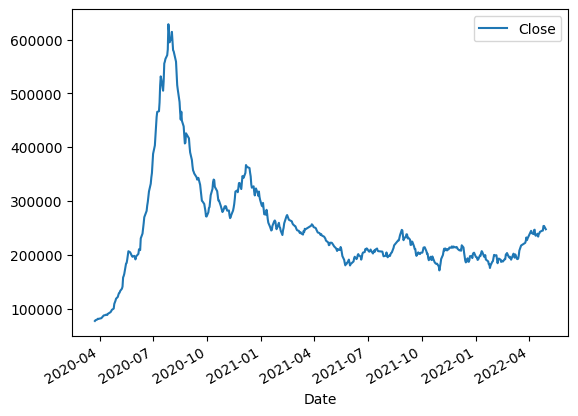

In [76]:
all_df = df
all_df.plot()

In [77]:
from scipy.stats import zscore
df = df.apply(zscore)

In [78]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, 
                                '2021-03-28', 
                                '2022-04-25', 
                                n=3)
windowed_df



,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-28,-0.031021,-0.041521,0.029658,0.055765
1,2021-03-30,-0.041521,0.029658,0.055765,0.030030
2,2021-03-31,0.029658,0.055765,0.030030,0.001763
3,2021-04-03,0.055765,0.030030,0.001763,-0.012448
4,2021-04-04,0.030030,0.001763,-0.012448,-0.023786
...,...,...,...,...,...
254,2022-04-18,-0.164263,-0.125454,-0.181389,-0.127511
255,2022-04-19,-0.125454,-0.181389,-0.127511,-0.119429
256,2022-04-20,-0.181389,-0.127511,-0.119429,-0.089880
257,2022-04-24,-0.127511,-0.119429,-0.089880,-0.065613


<Axes: >

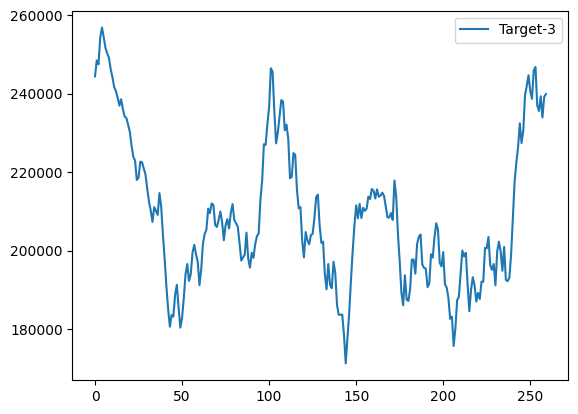

In [79]:
windowed_df_all = df_to_windowed_df(all_df, 
                                    '2021-03-25', 
                                    '2022-04-25', 
                                    n=3)

all_df_range = windowed_df_all[['Target-3']]
all_df_range.plot()

In [80]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape



((259,), (259, 3, 1), (259,))

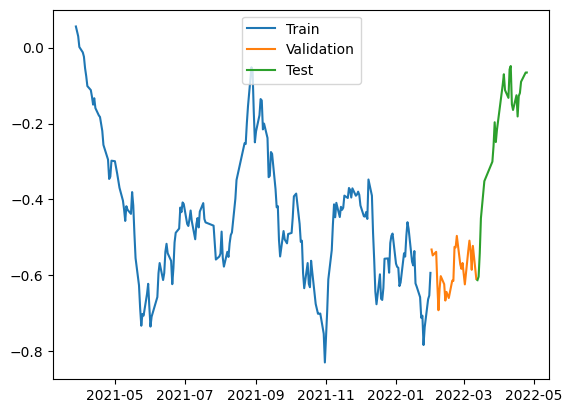

In [81]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test']);




In [82]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100);




Epoch 1/100
7/7 [==============================] - 2s 68ms/step - loss: 0.1859 - mean_absolute_error: 0.3976 - val_loss: 0.1699 - val_mean_absolute_error: 0.4089
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0638 - mean_absolute_error: 0.2164 - val_loss: 0.0100 - val_mean_absolute_error: 0.0863
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0196 - mean_absolute_error: 0.1158 - val_loss: 0.0076 - val_mean_absolute_error: 0.0745
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0133 - mean_absolute_error: 0.0904 - val_loss: 0.0177 - val_mean_absolute_error: 0.1237
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0129 - mean_absolute_error: 0.0922 - val_loss: 0.0062 - val_mean_absolute_error: 0.0645
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_absolute_error: 0.0731 - val_loss: 0.0026 - val_mean_absolute_error: 0.0434
Epoch 7/100
7/7 [================

7/7 [==============================] - 0s 2ms/step


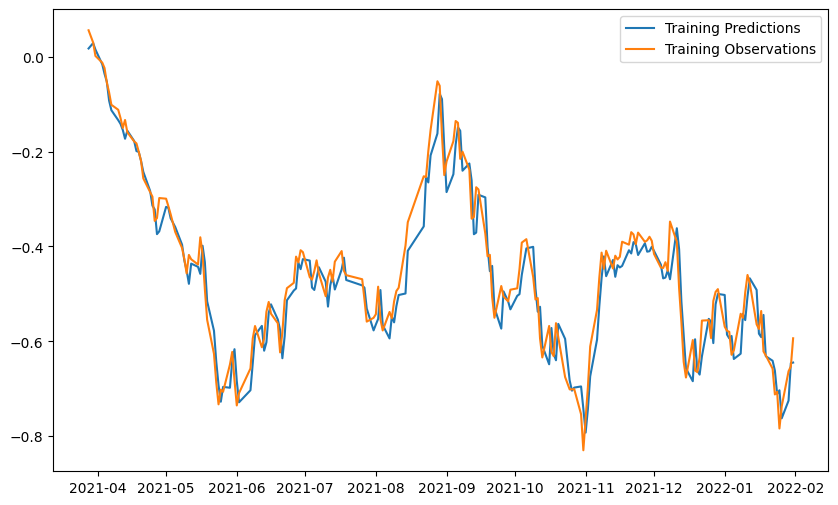

In [83]:
train_predictions = model.predict(X_train).flatten()

fig = plt.figure(figsize=(10, 6))

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations']);




1/1 [==============================] - 0s 19ms/step


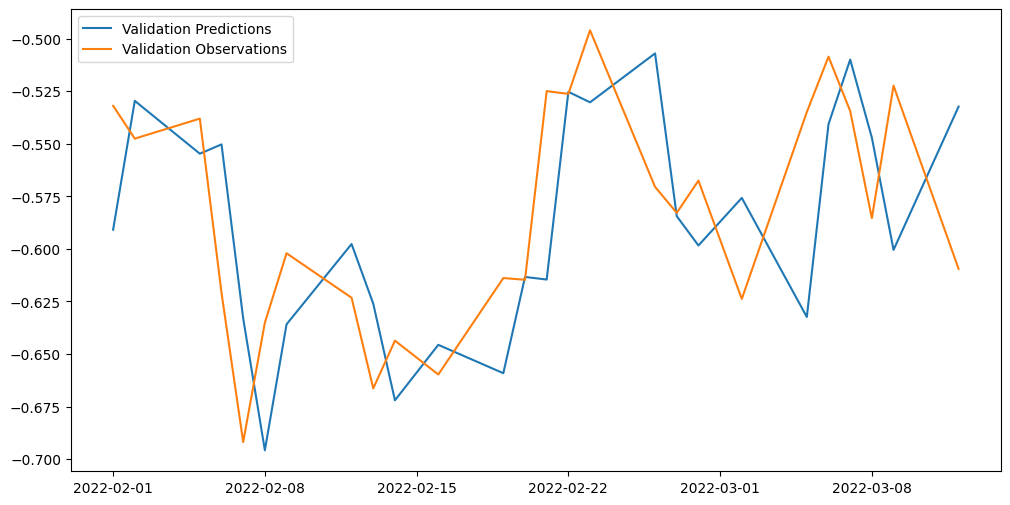

In [84]:
val_predictions = model.predict(X_val).flatten()

fig = plt.figure(figsize=(12, 6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations']);




1/1 [==============================] - 0s 21ms/step


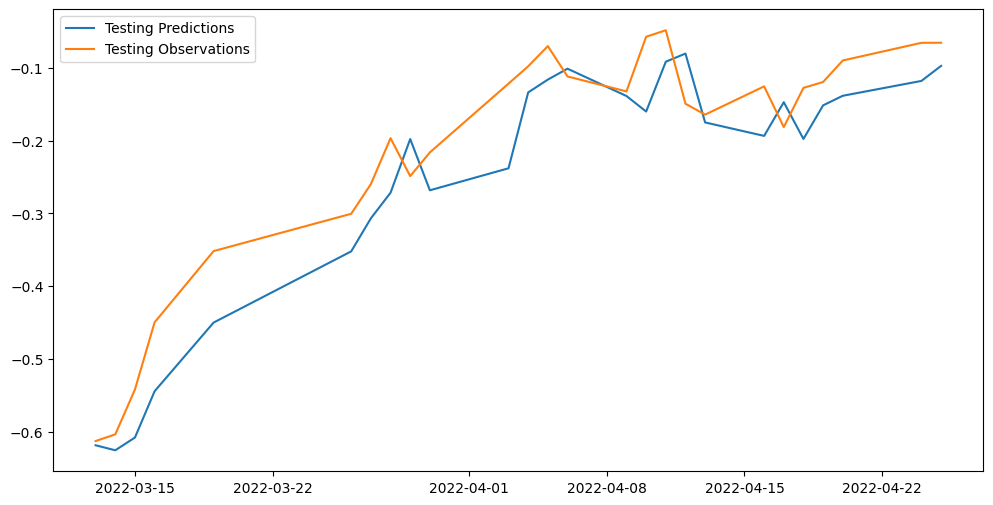

In [85]:
test_predictions = model.predict(X_test).flatten()
fig = plt.figure(figsize=(12, 6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations']);




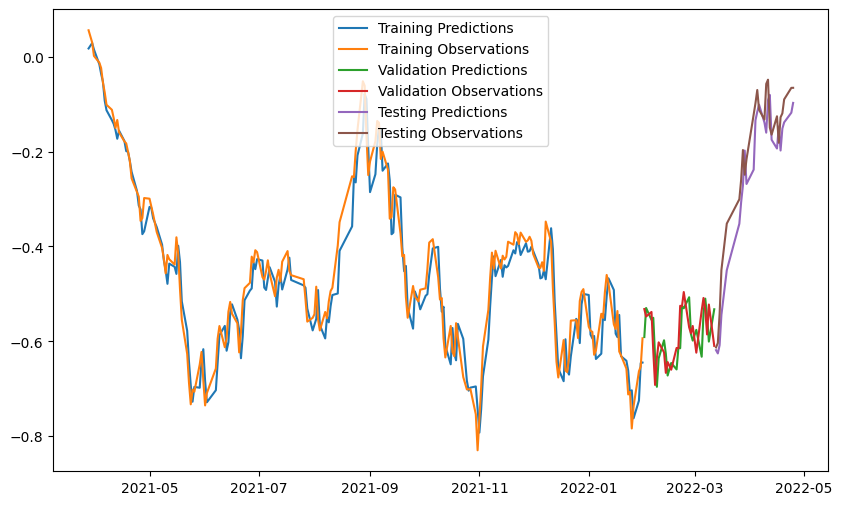

In [86]:
fig = plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations']);




In [87]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction




1/1 [==============================] - 0s 20ms/step


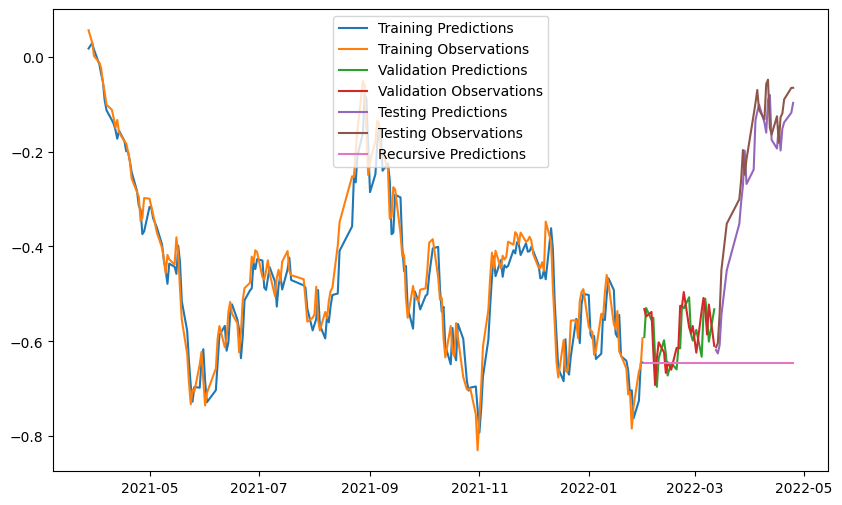

In [88]:
fig = plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions']);